In [1]:
import torch
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
from torch.utils.data import DataLoader
from transformers import AdamW, TrainingArguments
from tqdm.auto import tqdm
import evaluate
from accelerate import Accelerator

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import nltk

# Load the dataset
df = pd.read_csv('sentence_train.csv')

# Basic Information and Summary Statistics
print("Dataset Information:")
print(df.info())

print("\nDescriptive Statistics for Label:")
print(df['label'].describe().to_markdown(numalign="left", stralign="left"))

print("\nDescriptive Statistics for Review Length:")
df['review_length'] = df['cleaned_text'].apply(len)
print(df['review_length'].describe().to_markdown(numalign="left", stralign="left"))



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         8544 non-null   int64 
 1   cleaned_text  8544 non-null   object
dtypes: int64(1), object(1)
memory usage: 133.6+ KB
None

Descriptive Statistics for Label:
|       | label   |
|:------|:--------|
| count | 8544    |
| mean  | 2.05805 |
| std   | 1.28157 |
| min   | 0       |
| 25%   | 1       |
| 50%   | 2       |
| 75%   | 3       |
| max   | 4       |

Descriptive Statistics for Review Length:
|       | review_length   |
|:------|:----------------|
| count | 8544            |
| mean  | 136.027         |
| std   | 68.8262         |
| min   | 5               |
| 25%   | 83              |
| 50%   | 130             |
| 75%   | 182             |
| max   | 368             |


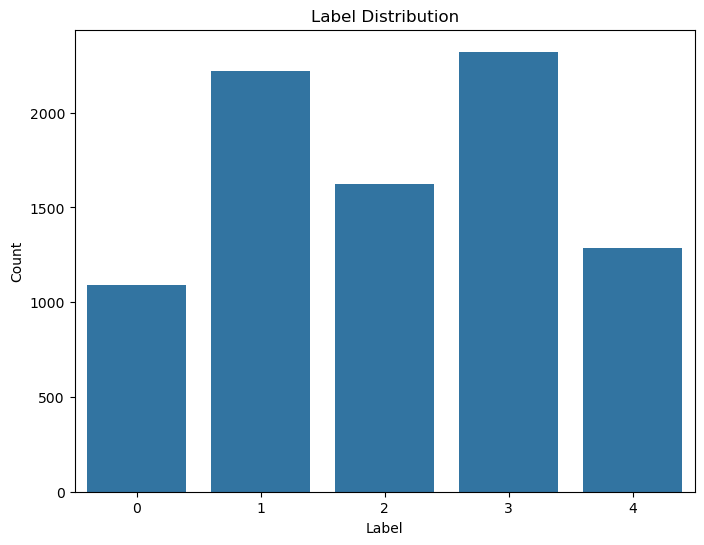

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


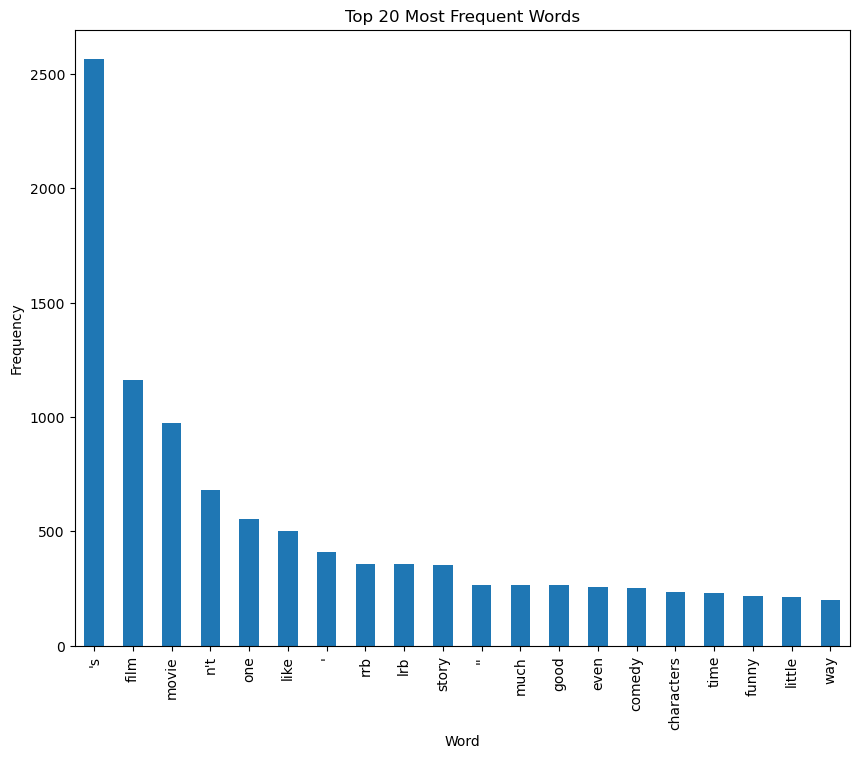

In [16]:
# Label Distribution Visualization
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Review Length Distribution Visualization
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('review_length:Q', bin=True, title='Review Length'),
    y=alt.Y('count()', title='Frequency'),
    tooltip=[alt.Tooltip('review_length:Q', bin=True, title='Review Length'), 'count()']
).properties(
    title='Distribution of Review Lengths'
).interactive()

chart.save('review_length_histogram.json')


# Word Frequency Analysis (Top 20 Words)
nltk.download('stopwords')
from nltk.corpus import stopwords

all_words = ' '.join(df['cleaned_text']).lower().split()
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words]
word_freq = pd.Series(filtered_words).value_counts()

plt.figure(figsize=(10, 8))
word_freq[:20].plot(kind='bar')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

BASIC EDA

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("rohith2812/STANFORD-SENTIMENT-TREEBANK")
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["cleaned_text"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Repo card metadata block was not found. Setting CardData to empty.
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


For have given the text files which contains movie reviews and its respective labels, i have cleaned the data and uploaded the data into hugging face and downloaded the same from hugging face for training the model. I have used the bert base cased model as given and imported the same tokenizer and applied the tokenized function.

In [3]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'cleaned_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['label', 'cleaned_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1101
    })
})

This are after applying the tokenizzer, it converted the respective text into tensors labeled as input_ids, along with that it has token_type_ids and attention_mask.

In [4]:
tokenized_datasets = tokenized_datasets.remove_columns(["cleaned_text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

As the model takes only the tenosors(numerical representation) i have dropped the column cleaned_text

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

Applied batching and i chose to applying the padding after batching so that theres no need to look for the maximum length of the text of entire dataset

In [6]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 66]),
 'token_type_ids': torch.Size([8, 66]),
 'attention_mask': torch.Size([8, 66])}

for a single batch the maximum length is 66 after padding

In [7]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.6697, grad_fn=<NllLossBackward0>) torch.Size([8, 5])


In [30]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

These are layers present in the bert base cased model, i just used this model and fine tuned the weights based on the dataset 

In [9]:
import torch
from tqdm import tqdm
from datasets import load_metric

# Load accuracy metric
accuracy_metric = load_metric("accuracy")

from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

# Initialize Accelerator
accelerator = Accelerator()

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Prepare the dataloaders and model with Accelerator
train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)


num_epochs = 5 
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode
    
    total_loss = 0
    total_correct = 0
    num_samples = 0
    
    for batch in train_dl:
        outputs = model(**batch)
        loss = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        total_loss += loss.item()
        total_correct += (predictions == labels).sum().item()
        num_samples += len(labels)

        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    avg_loss = total_loss / num_samples
    accuracy = total_correct / num_samples

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training loss: {avg_loss:.4f}")
    print(f"Training accuracy: {accuracy:.4f}")

    # Evaluate on the validation set
    model.eval()  # Set the model to evaluation mode
    
    total_eval_loss = 0
    total_eval_correct = 0
    num_eval_samples = 0
    
    for batch in eval_dl:
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]
        
            total_eval_loss += loss.item()
            total_eval_correct += (predictions == labels).sum().item()
            num_eval_samples += len(labels)
    
    avg_eval_loss = total_eval_loss / num_eval_samples
    eval_accuracy = total_eval_correct / num_eval_samples

    print(f"Validation loss: {avg_eval_loss:.4f}")
    print(f"Validation accuracy: {eval_accuracy:.4f}")

/tmp/ipykernel_833/768120370.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will b

Epoch 1/5
Training loss: 0.1617
Training accuracy: 0.4283


 20%|██        | 1069/5340 [01:27<34:42,  2.05it/s]

Validation loss: 0.1447
Validation accuracy: 0.4923


 40%|███▉      | 2135/5340 [02:52<04:31, 11.80it/s]

Epoch 2/5
Training loss: 0.1235
Training accuracy: 0.5757


 40%|████      | 2137/5340 [02:55<26:35,  2.01it/s]

Validation loss: 0.1471
Validation accuracy: 0.4832


 60%|█████▉    | 3203/5340 [04:20<03:01, 11.76it/s]

Epoch 3/5
Training loss: 0.0836
Training accuracy: 0.7230


 60%|██████    | 3205/5340 [04:23<17:41,  2.01it/s]

Validation loss: 0.1719
Validation accuracy: 0.4796


 80%|███████▉  | 4271/5340 [05:48<01:21, 13.05it/s]

Epoch 4/5
Training loss: 0.0446
Training accuracy: 0.8708


 80%|████████  | 4273/5340 [05:51<08:47,  2.02it/s]

Validation loss: 0.2328
Validation accuracy: 0.4650


100%|█████████▉| 5339/5340 [07:16<00:00, 12.57it/s]

Epoch 5/5
Training loss: 0.0176
Training accuracy: 0.9556
Validation loss: 0.2825
Validation accuracy: 0.4650


100%|██████████| 5340/5340 [07:30<00:00, 12.57it/s]

Fine Tuned the model here, used the adamw optimizer and learning rate of 5e-5, first i have uised 3e-5 but the results weren't promising so changed it to 5e-5, also updated the num_epochs from 3 to 5.
used linear method for backward propagation to learn the weights. once the model is applied we will get the outputs in the form of logits so used agmax to convert the logits better understand the output.

observing the pattern of training accuracy and validation accuracy, the training accuracy went on increased and validation accuracy started decreased from epoch 3 which suggests the model might be overfitting.

In [10]:
    model.eval()
    total_eval_loss = 0
    total_eval_correct = 0
    num_eval_samples = 0
    
    for batch in eval_dl:
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]
        
            total_eval_loss += loss.item()
            total_eval_correct += (predictions == labels).sum().item()
            num_eval_samples += len(labels)
    
    avg_eval_loss = total_eval_loss / num_eval_samples
    eval_accuracy = total_eval_correct / num_eval_samples

    print(f"Validation loss: {avg_eval_loss:.4f}")
    print(f"Validation accuracy: {eval_accuracy:.4f}")

Validation loss: 0.2825
Validation accuracy: 0.4650


In [12]:

review_text = "Prabhas' latest film, Kalki, is nothing short of a cinematic marvel that transcends the boundaries of conventional storytelling. This epic saga, directed by the visionary filmmaker Nag Ashwin, masterfully blends mythology, action, and drama to create a mesmerizing experience for audiences."

inputs = tokenizer(review_text, return_tensors="pt", padding=True, truncation=True)

# Move tensors to the same device as the model
inputs = {key: value.to(model.device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = logits.argmax(dim=-1)

# Define a mapping from label indices to sentiment
label_map = {
    0: "Very Negative",
    1: "Negative",
    2: "Neutral",
    3: "Positive",
    4: "Very Positive"
}

# Get the predicted label
predicted_label = predictions.item()
predicted_sentiment = label_map[predicted_label]

print(f"Review: {review_text}")
print(f"Predicted Label: {predicted_label} ({predicted_sentiment})")


Review: Prabhas' latest film, Kalki, is nothing short of a cinematic marvel that transcends the boundaries of conventional storytelling. This epic saga, directed by the visionary filmmaker Nag Ashwin, masterfully blends mythology, action, and drama to create a mesmerizing experience for audiences.
Predicted Label: 4 (Very Positive)


Tested the model on recently released kalki review and it performed well